In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from astropy import table
from astropy.table import Table, join
from astropy.io import ascii
import astropy.io.fits as pyfits
import itertools
import os
import sys
# sys.path.append('/home/maykerchen.1/Desktop/PythonFunctions')
sys.path.append('/Users/nessmayker/Desktop/PythonFunctions')
from detectionFraction import detecFrac
from cumulativeDistFunc import makeCDF
from findPercentiles import findStats
from flattenList import flatten
from nonZeroError import findErrVals
from findAtIndex import findClosest

#import SNe data 
File = '../Data/2.MUSESampleCat.csv'
data = Table.read(File, format='csv') 

data[0:5]

Galaxy,Distance,Incl,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSEHII,IRACfiles,Intensity,coptMap,InSample
str7,float64,float64,str11,str12,float64,float64,float64,str71,str70,str50,str40,float64,str58,str4
NGC1087,15.85,42.9,SN1995V,II,41.61152777777777,-0.4987861111111111,0.92,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1087-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,../Data/IRAC/ngc1087_irac1_atGauss4.fits,8.839672735197591e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr.fits,True
NGC1300,18.99,31.8,SN2022acko,II,49.91245833333333,-19.39518888888889,0.89,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1300-0.89asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1300-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1300_nebulae_mask_V2.fits,../Data/IRAC/ngc1300_irac1_atGauss4.fits,3.445745101042276e+38,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1300_sfr.fits,True
NGC1365,19.57,55.4,SN1957C,Unclassified,53.38349999999999,-36.11770833333333,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,2.938518960212585e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1365_sfr.fits,True
NGC1365,19.57,55.4,SN1983V,Ic,53.381876388888884,-36.14859166666667,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,1.4845660990817182e+40,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1365_sfr.fits,True
NGC1365,19.57,55.4,SN2001du,II,53.3713125,-36.142111111111106,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,1.3530435354080875e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1365_sfr.fits,True


In [3]:
# Find which SNe have finite intensity values 
finite = np.argwhere(np.isfinite(data["Intensity"]))

# Create array of intensity, error, SNR is high so dont neet to worry about
values       = data["Intensity"][finite]
# errors       = data["error"][finite]
# SNRvalues    = values/errors
# print(np.mean(SNRvalues))
incls        = data["Incl"][finite]

# change NGC4945's inclination from 90 to 85 and take cosine for incl factor 
incls = np.clip(incls, 0,85)
cosi = np.cos(incls*np.pi/180)

# isolate discovery year
year = []
for j in range(len(data)):
    yearDigits = [int(i) for i in data["Supernova"][j] if i.isdigit()]
    # fix for ASAS-SN14
    if len(yearDigits)<4:
        yearDigits.insert(0,0)
        yearDigits.insert(0,2)
    yearDigits = int(''.join(map(str,yearDigits)))
    year.append(yearDigits)
    
#flag SNe since 2000
goodSample = np.where(np.asarray(year) > 1999, 1, 0)
goodSample



array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1])

In [4]:
SNtype = data["Type"]

# homogonize type classifications
for i in range(len(SNtype)):
    if "II" == SNtype[i][:2]:
        SNtype[i] = "II"
    elif "Ia" == SNtype[i][:2]:
        SNtype[i] = "Ia"
    elif SNtype[i] == "I" or "U" == SNtype[i][:1]:
        SNtype[i] = "Unclassified"
    else:
        SNtype[i] = "Ib/c"

print(SNtype)
# Sort SN Type 
typeII_idx   = np.where(SNtype=="II")
typeIa_idx   = np.where(SNtype=="Ia")
typeIbc_idx  = np.where(SNtype=="Ib/c")
typeUnc_idx  = np.where(SNtype=="Unclassified")

numTypeII  = len(typeII_idx[0])
numTypeIa  = len(typeIa_idx[0])
numTypeIbc = len(typeIbc_idx[0])
numTypeUnc = len(typeUnc_idx[0])

print("Type II: ",numTypeII)
print("Type Ia: ",numTypeIa)
print("SESNe: ",numTypeIbc)
print("Unclassified: ",numTypeUnc)
print(len(SNtype))

    Type    
------------
          II
          II
Unclassified
        Ib/c
          II
          Ia
          II
         ...
          Ia
          II
Unclassified
Unclassified
          Ia
        Ib/c
        Ib/c
Length = 33 rows
Type II:  19
Type Ia:  6
SESNe:  5
Unclassified:  3
33


In [5]:
# get SN intensities by type
II_int = data["Intensity"][typeII_idx]
Ia_int = data["Intensity"][typeIa_idx]
Ibc_int = data["Intensity"][typeIbc_idx]
Unc_int = data["Intensity"][typeUnc_idx]


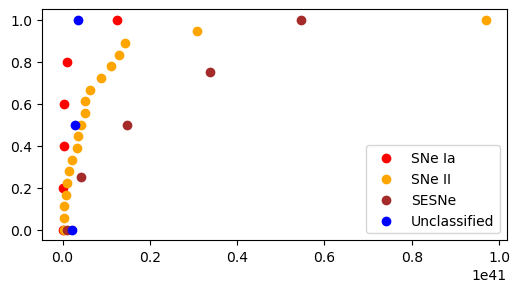

In [6]:
# make the y arrays to have the right number of entries
def makeYs(num):
    y  = np.linspace(0.0, 1.0, num)
    return(y)

yIa  = makeYs(numTypeIa)
yII  = makeYs(numTypeII)
yIbc = makeYs(numTypeIbc)
yUnc = makeYs(numTypeUnc)

# plot the intensities by type
plt.figure(figsize = (6,3))
plt.scatter(np.sort(Ia_int), yIa, label = "SNe Ia", color = "red")
plt.scatter(np.sort(II_int), yII, label = "SNe II", color = "orange")
plt.scatter(np.sort(Ibc_int), yIbc, label = "SESNe", color = "brown")
plt.scatter(np.sort(Unc_int), yUnc, label = "Unclassified", color = "blue")

plt.legend(loc='best')

In [7]:
# make CDFs of all and by type
CDFAll, yAll = makeCDF(data["Intensity"])
CDFII, yII   = makeCDF(II_int)
CDFIa, yIa   = makeCDF(Ia_int)
CDFIbc, yIbc = makeCDF(Ibc_int)
CDFUnc, yUnc = makeCDF(Unc_int)

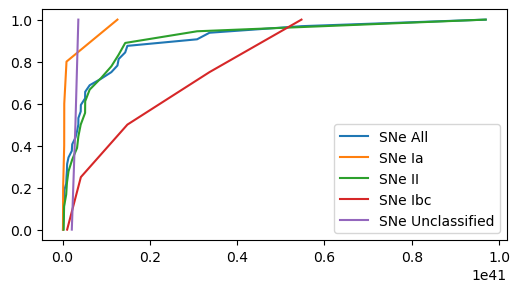

In [8]:
# plot the CDFs
plt.figure(figsize = (6,3))
plt.plot(CDFAll, yAll, label = "SNe All", ls="-")
plt.plot(CDFIa, yIa, label = "SNe Ia", ls="-")
plt.plot(CDFII, yII, label = "SNe II", ls="-")
plt.plot(CDFIbc, yIbc, label = "SNe Ibc", ls="-")
plt.plot(CDFUnc, yUnc, label = "SNe Unclassified", ls="-")

plt.legend(loc='best')

In [9]:
########### GETTING ALL PIXEL VALUES HERE #################

# Isolate unique galaxy names
unique_by_name = table.unique(data, keys='Galaxy')
galaxyName, intfile, distance, cosis = [],[],[],[]

# Create list of Filenames
for i in range(len(unique_by_name)):
    prefix = "/Users/nessmayker/Desktop/GalaxyFiles/MUSELargeFiles/SFR/copt/"
    galaxy = unique_by_name['Galaxy'][i]
    int_suffix = "_sfr.fits"
    intname =  prefix + galaxy + int_suffix
    
    dist = unique_by_name["Distance"][i]
    incl = unique_by_name["Incl"][i]
    
    if incl == 90:
        incl = 85
    cosi = np.cos(incl*np.pi/180)
    
    GalName = galaxy.strip().upper()
        
    intfile.append(intname) 
    galaxyName.append(galaxy)
    distance.append(dist)
    cosis.append(cosi)
    
# Pull intensity values out of galaxy maps for CDF and assign them as three sigma measurements or below

allIntensities = []

for i in range(len(intfile)):
    galaxy = galaxyName[i]
    
    if os.path.isfile(intfile[i]):
        
        hdu_int  = pyfits.open(intfile[i])   
        intmap   = hdu_int["HA_FLUX_CORR"].data        
        f_int    = intmap.flatten()       
        keep     = np.where(np.isfinite(f_int))
        inten    = f_int[keep]
        
        allIntensities.append(inten)
            
    else:
        print(intfile[i])
        print("No 150pc file for", unique_by_name['galaxy'][i])

allInt = list(itertools.chain.from_iterable(allIntensities))       


In [10]:
print(len(allInt))
print(np.median(allInt))
print(np.average(allInt))


8859113
2.1075747709646727e+38
2.7319670147450744e+39


In [11]:
# Make CDFs of all Measurements
CDFAllPixels, yAllPixels = makeCDF(allInt)


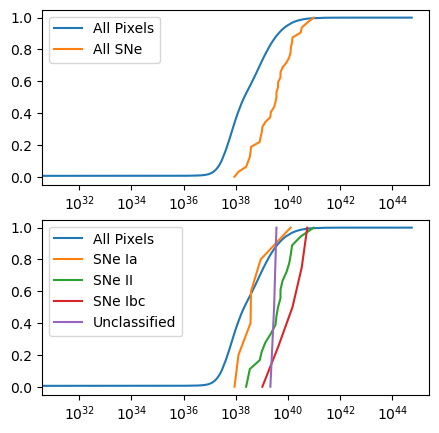

In [25]:
# plot the CDFs
fig,ax= plt.subplots(2, 1)   
fig.set_figheight(5)
fig.set_figwidth(5)
ax[0].semilogx(CDFAllPixels, yAllPixels, label = "All Pixels", ls="-")
ax[0].semilogx(CDFAll, yAll, label = "All SNe", ls="-")
ax[0].legend(loc='best')
ax[1].semilogx(CDFAllPixels, yAllPixels, label = "All Pixels", ls="-")
ax[1].semilogx(CDFIa, yIa, label = "SNe Ia", ls="-")
ax[1].semilogx(CDFII, yII, label = "SNe II", ls="-")
ax[1].semilogx(CDFIbc, yIbc, label = "SNe Ibc", ls="-")
ax[1].semilogx(CDFUnc, yUnc, label = "Unclassified", ls="-")
# plt.xlim(10**34,10**42)
ax[1].legend(loc='best')
plt.show()
fig.savefig("../Figures/IntensityCDFs.pdf", dpi=300)